In [1]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month 2w 3d


In [ ]:
import torch
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import pickle
import numpy as np
import seaborn as sns

In [13]:
torch.cuda.is_available()

True

In [14]:
# Download latest version
path = kagglehub.dataset_download("fedesoriano/cifar100")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\fedesoriano\cifar100\versions\1


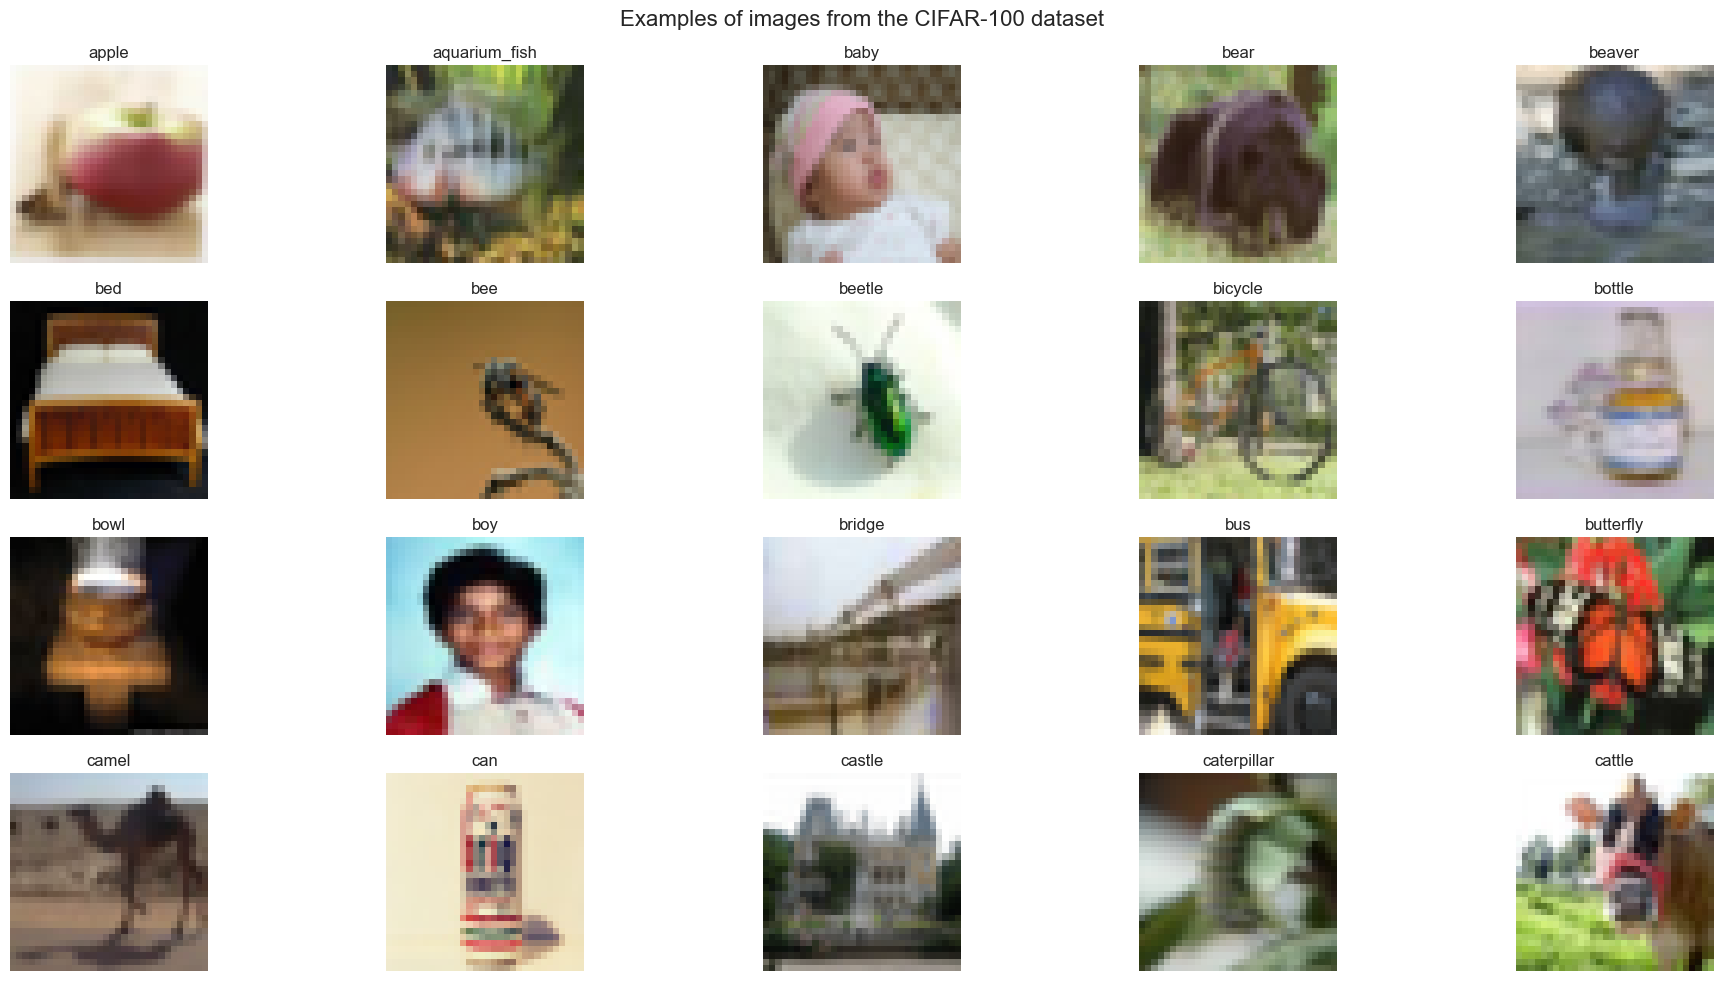

In [39]:
# Define paths to training data and metadata
train_path = os.path.join(path, "train")
meta_path = os.path.join(path, "meta")

# Load class names from metadata
with open(meta_path, 'rb') as f:
    meta = pickle.load(f, encoding='bytes')
    fine_label_names = [name.decode('utf-8') for name in meta[b'fine_label_names']]

# Load training data
with open(train_path, 'rb') as f:
    train_data = pickle.load(f, encoding='bytes')

X = train_data[b'data']
y = train_data[b'fine_labels']

# Reshape data into image format: (N, 32, 32, 3)
X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Convert numeric labels to class names
labels_named = [fine_label_names[i] for i in y]

# Create a DataFrame with images and labels
df = pd.DataFrame({
    'image': list(X),
    'label': labels_named
})

# Visualize one image from each of the first 20 unique classes
unique_classes = sorted(set(labels_named))
plt.figure(figsize=(20, 10))
for i, label in enumerate(unique_classes[:20]):
    idx = df[df['label'] == label].index[0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(df.loc[idx, 'image'])
    plt.title(label)
    plt.axis("off")

plt.suptitle("Examples of images from the CIFAR-100 dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [40]:
# Define paths to training data and metadata
train_path = os.path.join(path, "train")
meta_path = os.path.join(path, "meta")

# Load class names from metadata
with open(meta_path, 'rb') as f:
    meta = pickle.load(f, encoding='bytes')
    class_names = [name.decode('utf-8') for name in meta[b'fine_label_names']]

# Load training images and labels
with open(train_path, 'rb') as f:
    train_data = pickle.load(f, encoding='bytes')

X = train_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y = train_data[b'fine_labels']

# Create output directory for class folders
output_dir = "./cifar100_data/train"
os.makedirs(output_dir, exist_ok=True)

for class_name in class_names:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Save each image to the corresponding class folder
for idx in tqdm(range(len(X)), desc="Saving images"):
    img = Image.fromarray(X[idx])
    class_name = class_names[y[idx]]
    img_path = os.path.join(output_dir, class_name, f"{idx}.png")
    img.save(img_path)

Saving images: 100%|██████████| 50000/50000 [00:52<00:00, 947.85it/s] 


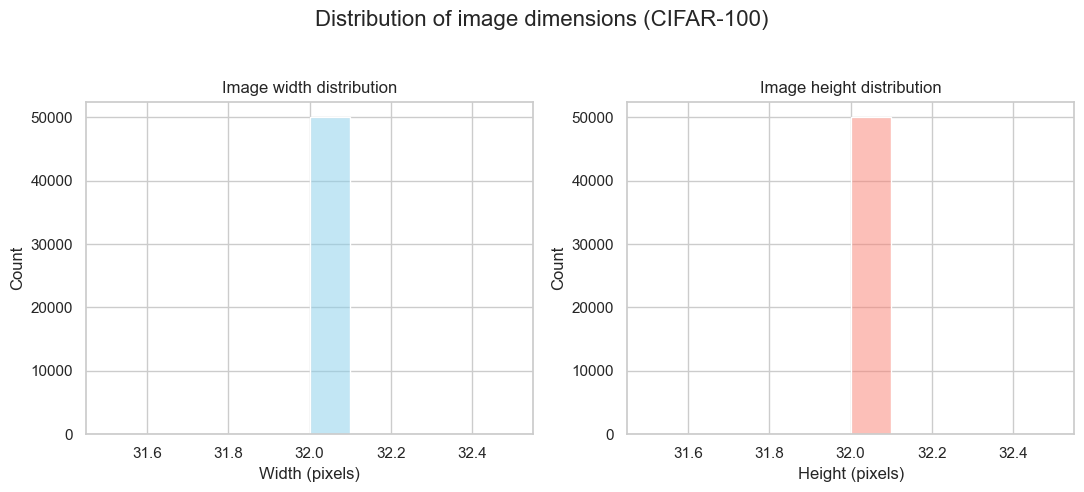

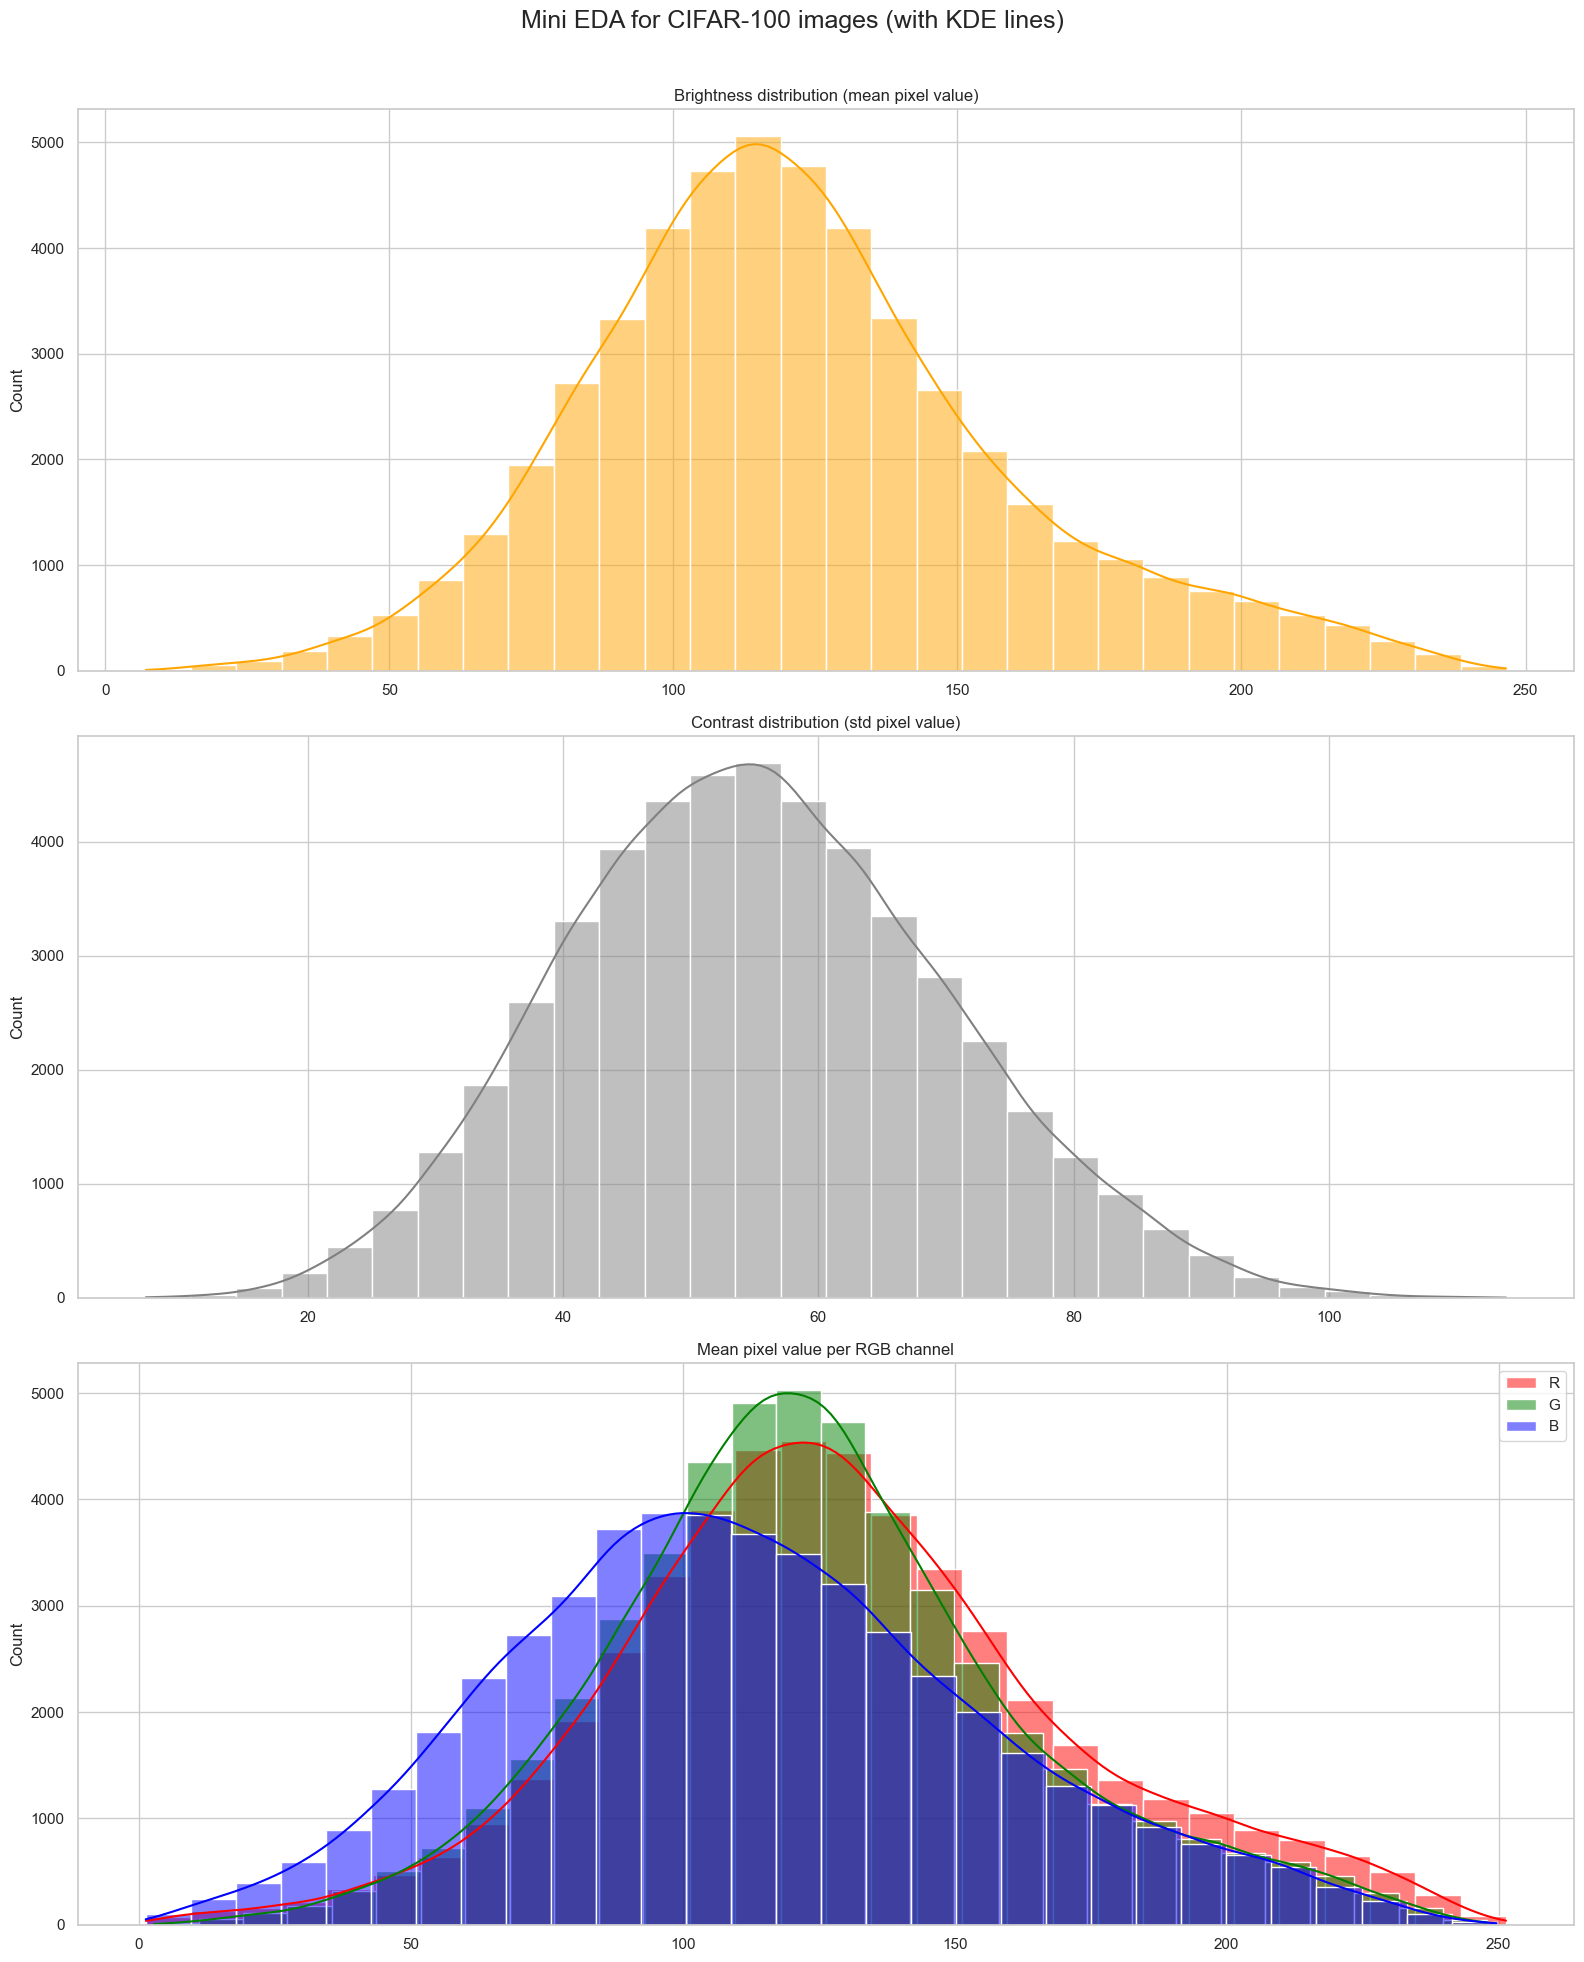

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Functions for computing brightness and contrast
def compute_brightness(img):
    return np.mean(img)

def compute_contrast(img):
    return np.std(img)

def compute_rgb_means(img):
    return np.mean(img[:, :, 0]), np.mean(img[:, :, 1]), np.mean(img[:, :, 2])

#  Calculate metrics for all images
widths, heights = [], []
brightness_list, contrast_list = [], []
r_means, g_means, b_means = [], [], []

for img in df['image']:
    h, w, _ = img.shape
    widths.append(w)
    heights.append(h)
    brightness_list.append(compute_brightness(img))
    contrast_list.append(compute_contrast(img))
    r, g, b = compute_rgb_means(img)
    r_means.append(r)
    g_means.append(g)
    b_means.append(b)

#  Plotting
sns.set(style="whitegrid")

# 1️⃣ Image dimensions (width and height distribution)
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
sns.histplot(widths, bins=10, kde=True, color='skyblue')
plt.title("Image width distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=10, kde=True, color='salmon')
plt.title("Image height distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.suptitle("Distribution of image dimensions (CIFAR-100)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(16, 20))

# 1️ Brightness distribution
plt.subplot(3, 1, 1)
sns.histplot(brightness_list, bins=30, kde=True, color='orange')
plt.title("Brightness distribution (mean pixel value)")

# 2️ Contrast distribution
plt.subplot(3, 1, 2)
sns.histplot(contrast_list, bins=30, kde=True, color='gray')
plt.title("Contrast distribution (std pixel value)")

# 3️ RGB channel means
plt.subplot(3, 1, 3)
sns.histplot(r_means, bins=30, kde=True, color='red', label='R', alpha=0.5)
sns.histplot(g_means, bins=30, kde=True, color='green', label='G', alpha=0.5)
sns.histplot(b_means, bins=30, kde=True, color='blue', label='B', alpha=0.5)
plt.legend()
plt.title("Mean pixel value per RGB channel")

plt.suptitle("Mini EDA for CIFAR-100 images (with KDE lines)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


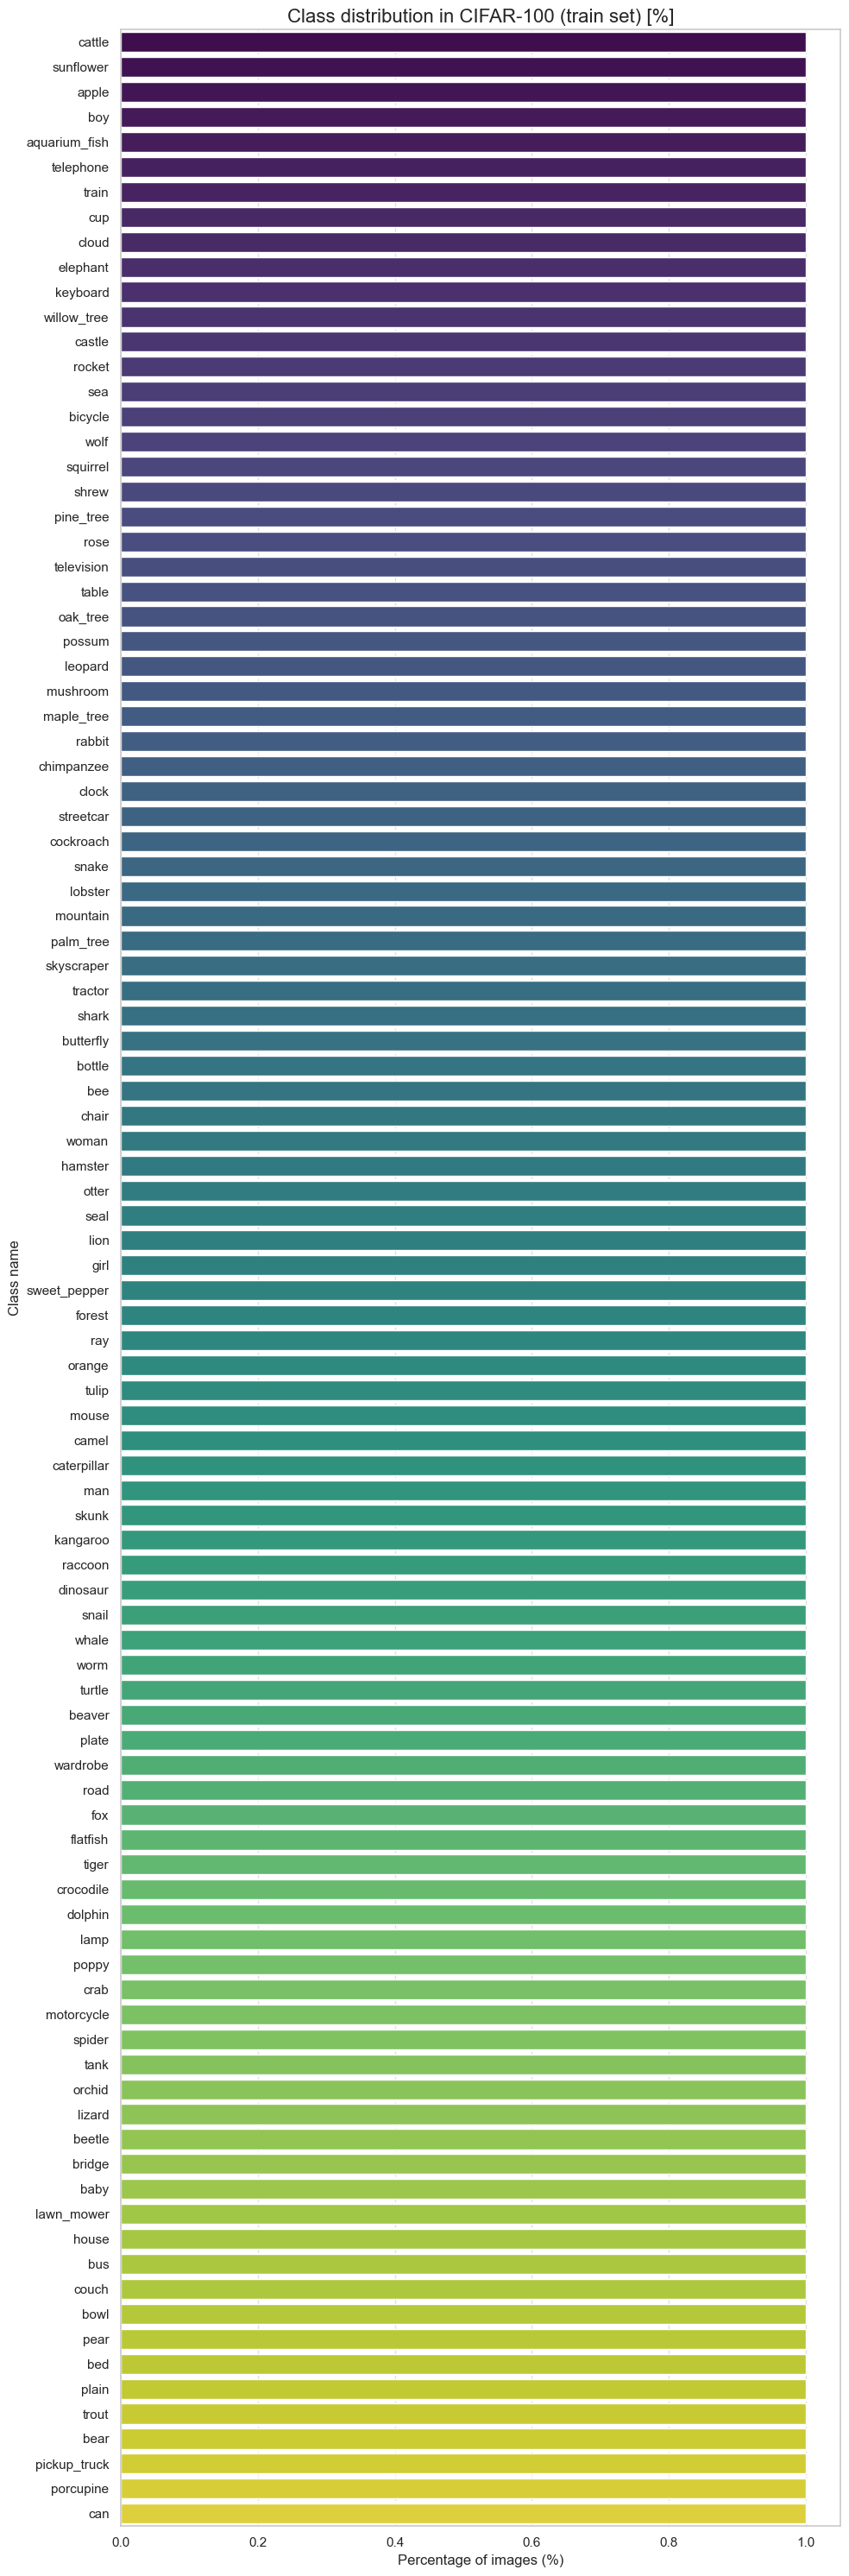

In [ ]:
#  Calculate class distribution in percentages
label_counts = df['label'].value_counts().sort_values(ascending=False)
label_percentages = (label_counts / label_counts.sum()) * 100

#  Plot horizontal bar chart
plt.figure(figsize=(10, 30))  # Высота под 100 классов
sns.barplot(x=label_percentages.values, y=label_percentages.index, palette='viridis')

plt.xlabel("Percentage of images (%)")
plt.ylabel("Class name")
plt.title("Class distribution in CIFAR-100 (train set) [%]", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



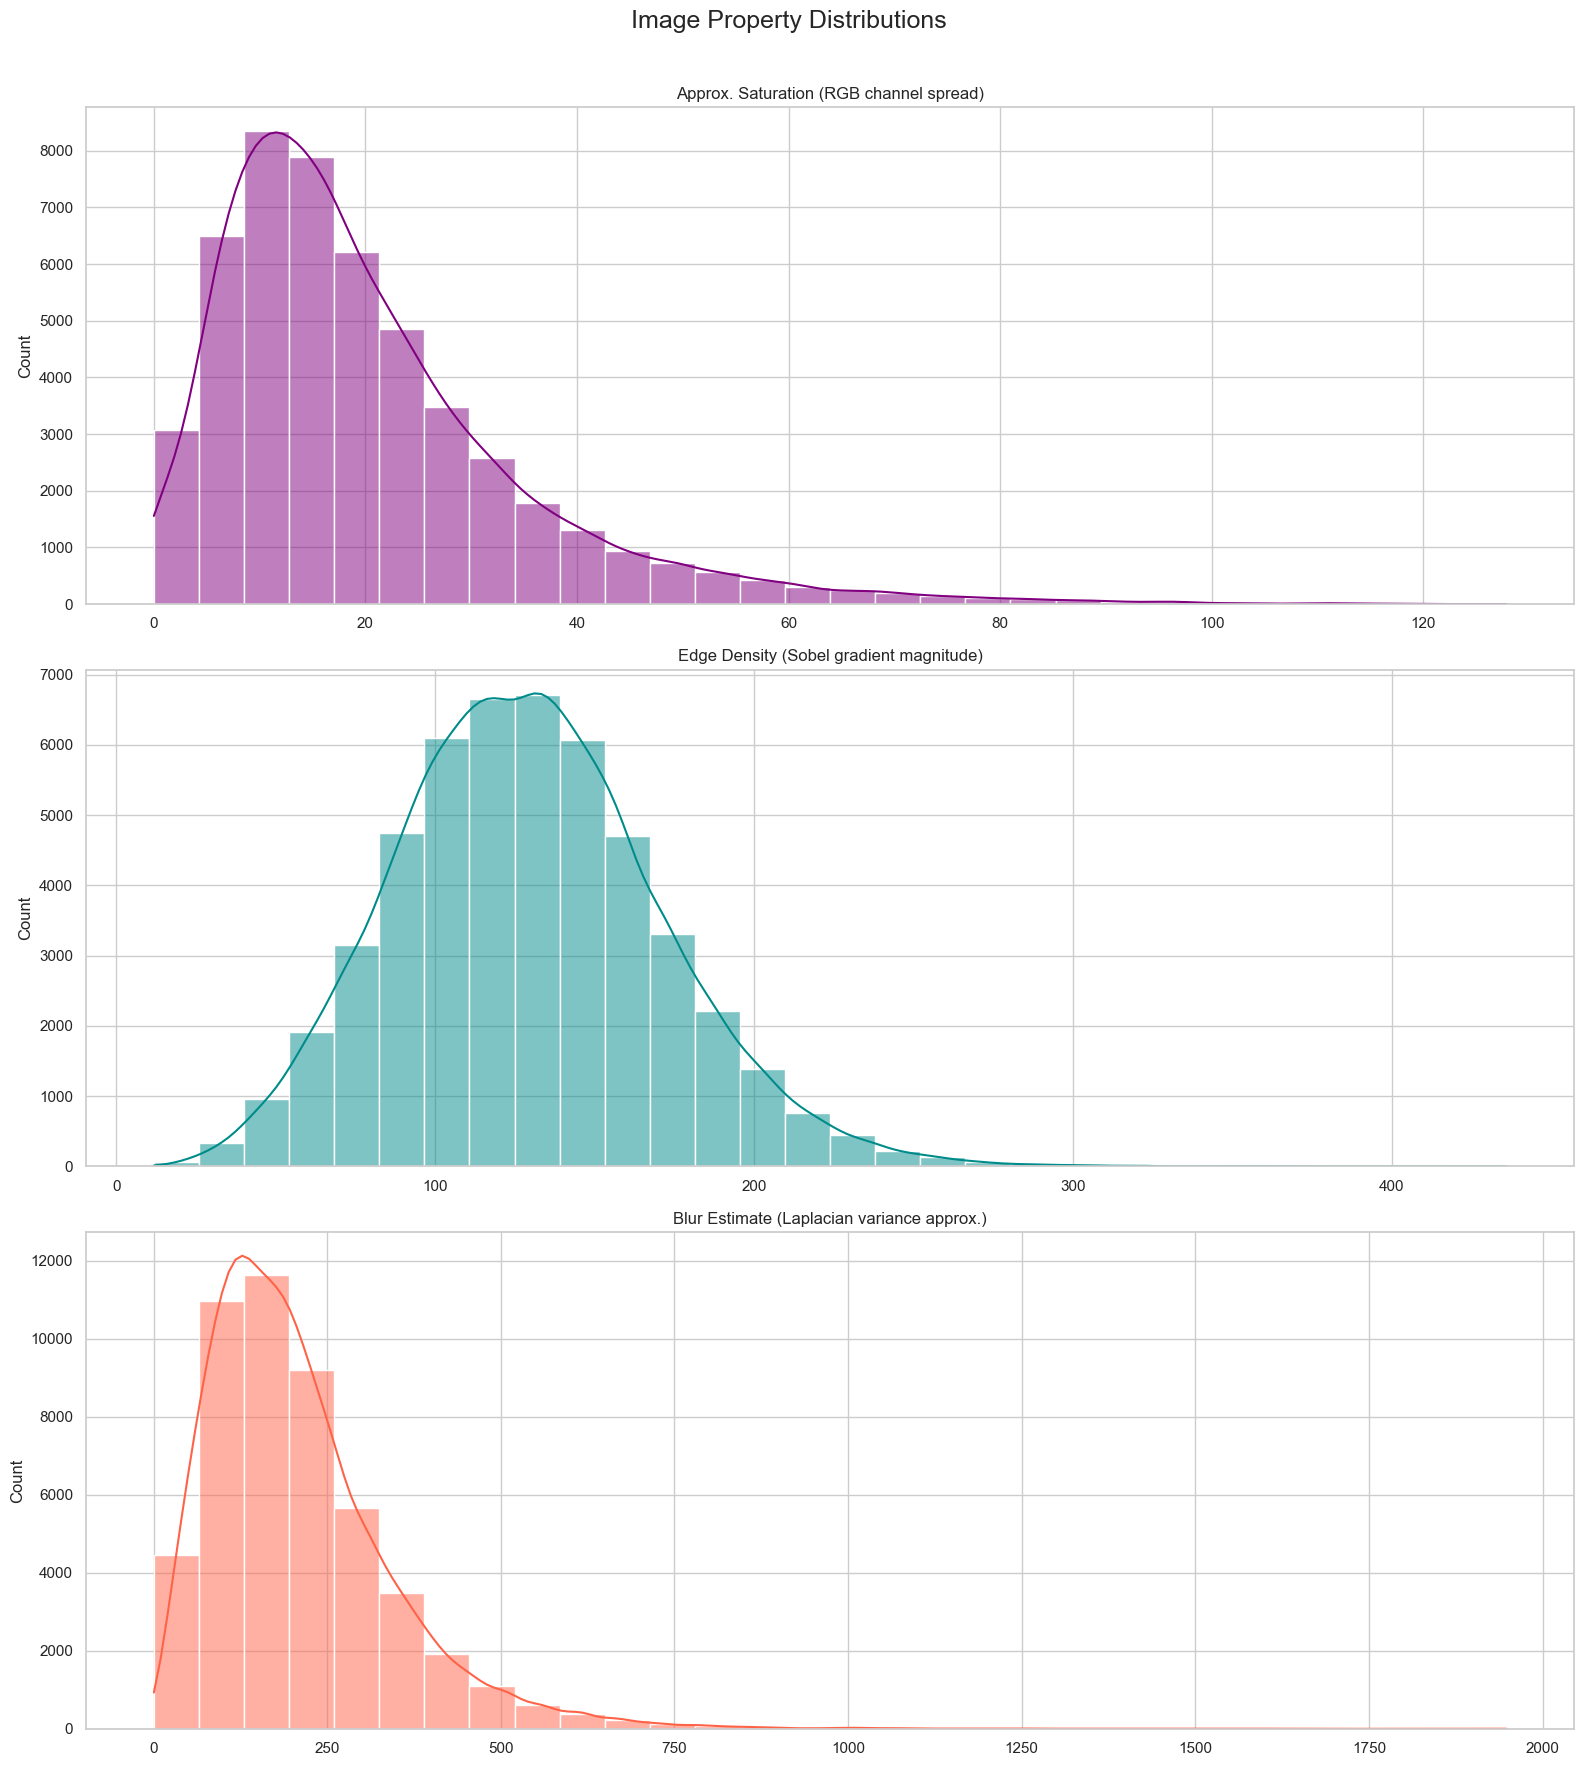

In [52]:
import numpy as np
from scipy.ndimage import gaussian_laplace, sobel
import matplotlib.pyplot as plt
import seaborn as sns

# 🔧 Альтернатива saturation: difference between max and mean RGB
def compute_saturation_simple(img):
    return np.mean(np.max(img, axis=2) - np.mean(img, axis=2))

# 🧠 Edge density: sobel gradient magnitude
def compute_edge_density(img):
    gray = np.mean(img, axis=2)
    sx = sobel(gray, axis=0)
    sy = sobel(gray, axis=1)
    gradient_magnitude = np.hypot(sx, sy)
    return np.mean(gradient_magnitude)

# 🔍 Blur estimate: variance of Laplacian approximation
def compute_blur(img):
    gray = np.mean(img, axis=2)
    lap = gaussian_laplace(gray, sigma=1.0)
    return np.var(lap)

# 📊 Сбор метрик
saturation_list = []
edge_density_list = []
blur_list = []

for img in df['image']:
    saturation_list.append(compute_saturation_simple(img))
    edge_density_list.append(compute_edge_density(img))
    blur_list.append(compute_blur(img))

sns.set(style="whitegrid")
plt.figure(figsize=(16, 18))

# Saturation
plt.subplot(3, 1, 1)
sns.histplot(saturation_list, bins=30, kde=True, color='purple')
plt.title("Approx. Saturation (RGB channel spread)")

# Edge density
plt.subplot(3, 1, 2)
sns.histplot(edge_density_list, bins=30, kde=True, color='darkcyan')
plt.title("Edge Density (Sobel gradient magnitude)")

# Blur
plt.subplot(3, 1, 3)
sns.histplot(blur_list, bins=30, kde=True, color='tomato')
plt.title("Blur Estimate (Laplacian variance approx.)")

plt.suptitle("Image Property Distributions ", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
